Disparity Initialization choose_fram ==100 sequence =[101 102 103 104 105 106 107 108]
Disparity Initialization for image 101
get_depth_map................................


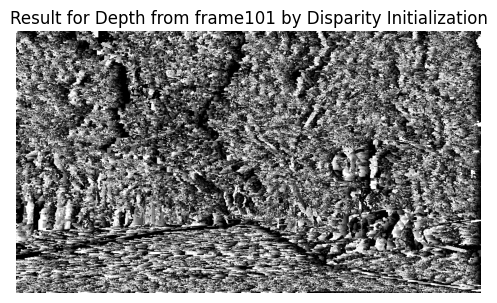

Disparity Initialization for image 102
get_depth_map................................


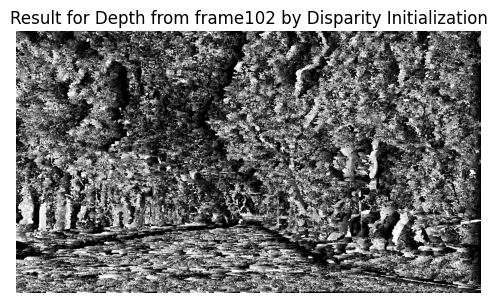

Disparity Initialization for image 103
get_depth_map................................


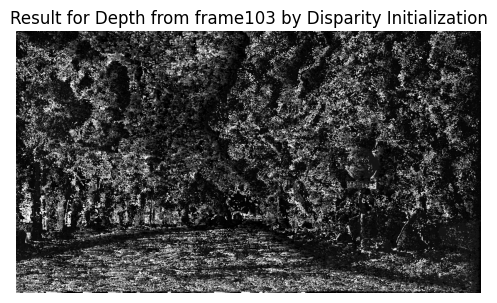

Disparity Initialization for image 104
get_depth_map................................


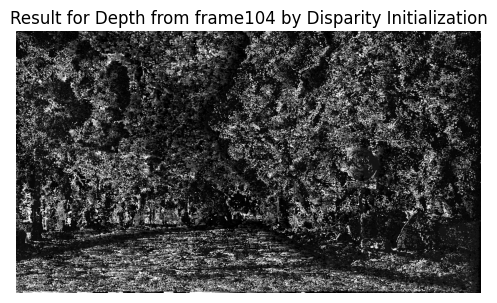

Disparity Initialization for image 105


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gco
import os


def homogeneous_coord_grid(h, w):
    X, Y = np.float32(np.meshgrid(
        np.arange(w, dtype=np.float32),
        np.arange(h, dtype=np.float32),
        indexing='xy'))

    X, Y, Z = (np.expand_dims(X, axis=0),
               np.expand_dims(Y, axis=0),
               np.ones([1, h, w], np.float32))

    return np.concatenate([X, Y, Z], axis=0)


def get_coordinates(K, R1, T1, R2, T2, coorsxy, d, h, w):
    coorsxy = np.reshape(coorsxy, [3, -1])
    # d = 

    depth = (T1 - T2).T * np.reshape(d, [1, -1])
    remap1 = (K * R2.T) * ((R1 * K.I) * coorsxy + depth)
    remap1 = np.divide(remap1, remap1[2, :])
    remap1 = np.reshape(np.asarray(remap1), [3, h, w])
    return remap1


def L2(img_a, img_b):
    return np.sqrt(np.sum(np.square(img_a - img_b), axis=-1, keepdims=True))


def L2_f(img_a, img_b):
    return np.sqrt(np.sum(np.square(img_a - img_b), axis=-1, keepdims=False))


def read_directory(directory_name):
    array_of_img = []
    for filename in os.listdir(r"./" + directory_name):
        img = cv.imread(directory_name + "/" + filename)
        array_of_img.append(np.float32(img))
    return array_of_img


def distance(x_h, projected_x_prime_h):
    return np.sum(np.square(x_h - projected_x_prime_h), axis=0, keepdims=False)


def load_depthmaps(directory, sequence):
    dd = []
    for i in range(len(sequence)):
        depthmap_name = os.path.join(directory, "depth_" + str(i).zfill(4) + ".npy")

        depthmap = np.load(depthmap_name)
        dd.append(depthmap)
    return dd


def load_params(filename):
    with open(filename, 'r') as f:
        frame_num = int(f.readline())
        f.readline()

        def read_vector():
            vec = f.readline().split()
            return np.array([float(x) for x in vec], dtype=np.float32)

        def read_matrix():
            r1 = read_vector()
            r2 = read_vector()
            r3 = read_vector()
            return np.matrix([r1, r2, r3], dtype=np.float32)

        K_sequence = [None] * frame_num
        R_sequence = [None] * frame_num
        T_sequence = [None] * frame_num

        for i in range(frame_num):
            K_sequence[i] = read_matrix()
            R_sequence[i] = read_matrix()
            T_sequence[i] = np.asmatrix(read_vector())
            f.readline()
            f.readline()
    return K_sequence, R_sequence, T_sequence


def remap(I_t_prime, x_prime):
    return cv.remap(
        src=I_t_prime,
        map1=x_prime,
        map2=None,
        interpolation=cv.INTER_NEAREST,
        borderValue=[128, 128, 128])


def get_smooth_simple(d_number, threshold):
    s = (1 - np.eye(d_number))
    # smooth = 1-np.eye(d_number)
    for i in range(d_number):
        for j in range(d_number):
            if i != j:
                s[i][j] = min(abs(i - j), threshold)
    return s


def get_depth_map(unary, smooth, lambda_factor=0.06):
    labels = gco.cut_grid_graph_simple(unary, smooth * lambda_factor, connect=4, n_iter=-1, algorithm='swap')
    labels = labels.reshape(H, W)
    return labels


def get_depth_map_HW(unary, smooth, H, W, lambda_factor=0.06):
    labels = gco.cut_grid_graph_simple(unary, smooth * lambda_factor, connect=4, n_iter=-1)
    labels = labels.reshape(H, W)
    return labels

Disparity Initialization choose_fram ==100 sequence =[101 102 103 104 105 106 107 108]
Disparity Initialization for image 101
get_depth_map................................


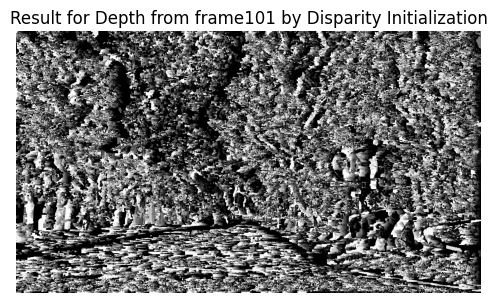

Disparity Initialization for image 102
get_depth_map................................


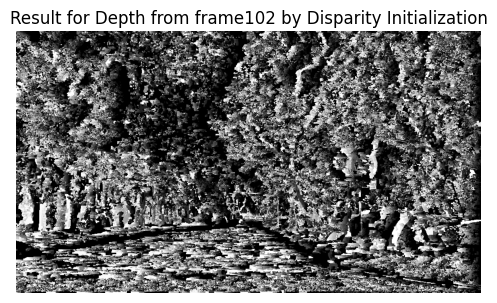

Disparity Initialization for image 103
get_depth_map................................


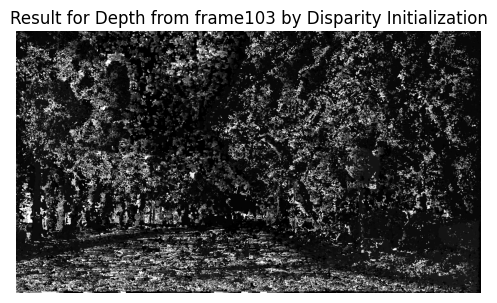

Disparity Initialization for image 104
get_depth_map................................


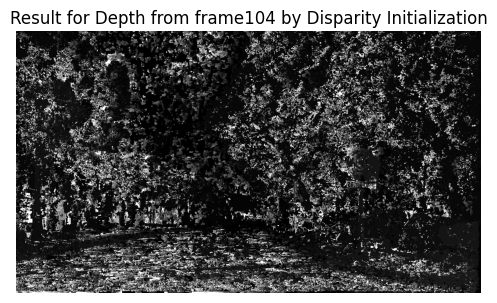

Disparity Initialization for image 105
get_depth_map................................


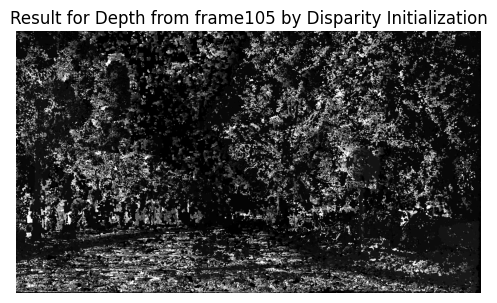

Disparity Initialization for image 106
get_depth_map................................


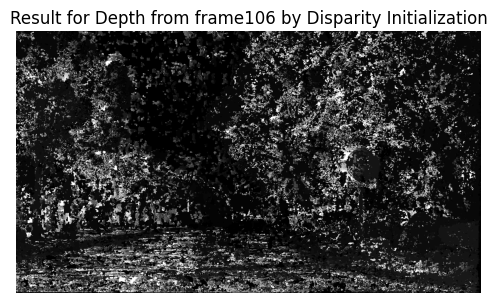

Disparity Initialization for image 107
get_depth_map................................


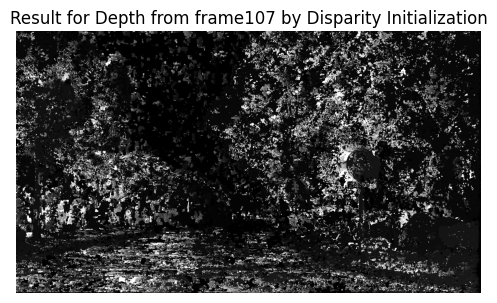

Disparity Initialization for image 108
get_depth_map................................


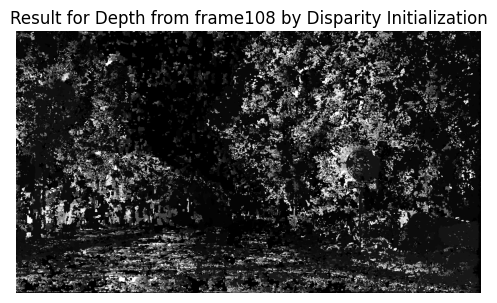

In [2]:
files = 'data/Road/src'
txt_path = 'data/Road/cameras.txt'
out_dir = 'data/Road/depth'

K, R, T = load_params(txt_path)
array_of_img = read_directory(files)

H, W, D = array_of_img[0].shape
disparity = np.arange(0, 0.02, 0.02 / 65)
d_numbers = len(disparity)

choose_frame = 100

sequence = np.array([101, 102, 103, 104, 105, 106, 107, 108])

num_frame = sequence.shape[0]
L = np.zeros((H, W, d_numbers))

print(f'Disparity Initialization choose_fram =={choose_frame} sequence ={sequence}')
use_bundle = False
depth_map_save = []
img1 = array_of_img[choose_frame]

h, w = H, W
I_t = img1
sigma_c = 1.0
sigma_d = 2.5

x_h = homogeneous_coord_grid(H, W)  #[3, h, w]
d = np.zeros([H, W], dtype=np.float32)  #[h, w]
L = np.zeros([d_numbers, H, W], dtype=np.float32)  #[d_numbers, h, w]
D = np.zeros([num_frame, H, W])
for i in range(num_frame):
    print(f'Disparity Initialization for image {sequence[i]}')
    I_t_prime = array_of_img[sequence[i]]
    fram = sequence[i]
    for d_number in range(d_numbers):

        d[:, :] = disparity[d_number]

        x_prime_h = get_coordinates(K[choose_frame], R[choose_frame], T[choose_frame], R[fram], T[fram], x_h, d, h, w)

        x_prime = np.transpose(x_prime_h[:2, :, :], [1, 2, 0])
        I_t_projected = remap(I_t_prime, x_prime)

        color_distance = L2(I_t, I_t_projected)
        pc = sigma_c / (sigma_c + color_distance)
        if not use_bundle:
            L[d_number, :, :] += pc[:, :, 0]

    u = np.reciprocal(L.max(axis=0, keepdims=True))
    unary = 1 - u * L
    final_unary = np.zeros((H, W, d_number))
    for k in range(d_number):
        final_unary[:, :, k] = unary[k, :, :]

    smooth = get_smooth_simple(d_number, threshold=10)

    depthmap = get_depth_map(final_unary, smooth, lambda_factor=0.3)
    D[i, :, :] = depthmap
    print('get_depth_map................................')
    plt.figure(num=1, dpi=100, figsize=(6, 6))
    plt.imshow(depthmap, cmap='gray')
    plt.title(f'Result for Depth from frame{sequence[i]} by Disparity Initialization')
    plt.axis("off")
    plt.show()
    # save for every frame of deptj:

    # depthmap_filename = os.path.join(out_dir, "depth_"+str(i).zfill(4))

    # np.save(depthmap_filename, depthmap)

    # Max = np.float32(depthmap.max())
    # cv.imwrite(depthmap_filename+'.png', np.uint8(depthmap/Max*255))


In [ ]:
print(f'Boundle Optimization: choose_fram =={choose_frame} sequence ={sequence}, frame{fram}')
for i in range(num_frame):
    I_t_prime = array_of_img[sequence[i]]
    # fram = sequence[i]
    print(f"solving img{sequence[i]}")
    for d_number in range(d_numbers):
        d[:, :] = disparity[d_number]

        x_prime_h = get_coordinates(K[choose_frame], R[choose_frame], T[choose_frame], R[fram], T[fram], x_h, d, h, w)

        x_prime = np.transpose(x_prime_h[:2, :, :], [1, 2, 0])
        I_t_projected = remap(I_t_prime, x_prime)
        color_difference = L2_f(I_t, I_t_projected)
        pc = sigma_c / (sigma_c + color_difference)

        # D = load_depthmaps(out_dir,sequence)
        depth_indices = np.array(D[i]).astype(np.int64)
        # print(depth_indices.shape)
        # depth_indices = 
        depth_indices_projected = remap(depth_indices, x_prime)
        # print(depth_indices_projected)
        np.take(disparity, depth_indices_projected, out=d)

        projected_x_prime_h = get_coordinates(K[fram], R[fram], T[fram], R[choose_frame], T[choose_frame], x_prime_h, d,
                                              h, w)
        color_distance = distance(x_h, projected_x_prime_h)

        pv = np.exp(color_distance / (-2 * sigma_d * sigma_d))

        L[d_number, :, :] += pc * pv

u = np.reciprocal(L.max(axis=0, keepdims=True))
unary = 1 - u * L
final_unary = np.zeros((H, W, d_number))
for i in range(d_number):
    final_unary[:, :, i] = unary[i, :, :]

smooth = get_smooth_simple(d_number, threshold=10)

print('get_depth_map................................')
depthmap = get_depth_map(final_unary, smooth, lambda_factor=0.06)
plt.figure(dpi=300, figsize=(24, 8))
plt.subplot(121)
plt.imshow(depthmap[:, 0:900], cmap='gray')
plt.title('Best Result for Depth from Video by using boundle optimization')
plt.axis("off")
plt.subplot(122)
plt.title('Origin image')
img = cv.imread(files + "/" + 'test0100.jpg')
img = img[:, :, [2, 1, 0]]
plt.imshow(img)
plt.show()
